# The Morris Lecar Model

This two-variable model creates excitability in the same form as the Hogkkin-Huxley equations. It uses a Kirchhoff equation (similar to HH) for self-excitation and a (single) gating variable to repolarize. 

Two sigmoids are used as nonlinear functions. 

The model exhibits all dynamical feature of firing neurons. It can also be expanded to include further currencs (e.g. Calcium) and then shows spontaneous bursting.


In [1]:
from numpy import tanh, cosh, linspace, arange
from matplotlib.pyplot import subplots
from scipy.integrate import solve_ivp


Morris-Lecar Model Parameters (Original 1981):
C = 20.0 μF/cm²
g_Ca = 4.4 mS/cm²
g_K = 8.0 mS/cm²
g_L = 2.0 mS/cm²
E_Ca = 120.0 mV
E_K = -84.0 mV
E_L = -60.0 mV
V1 = -1.2 mV
V2 = 18.0 mV
V3 = 2.0 mV
V4 = 30.0 mV
phi = 0.04


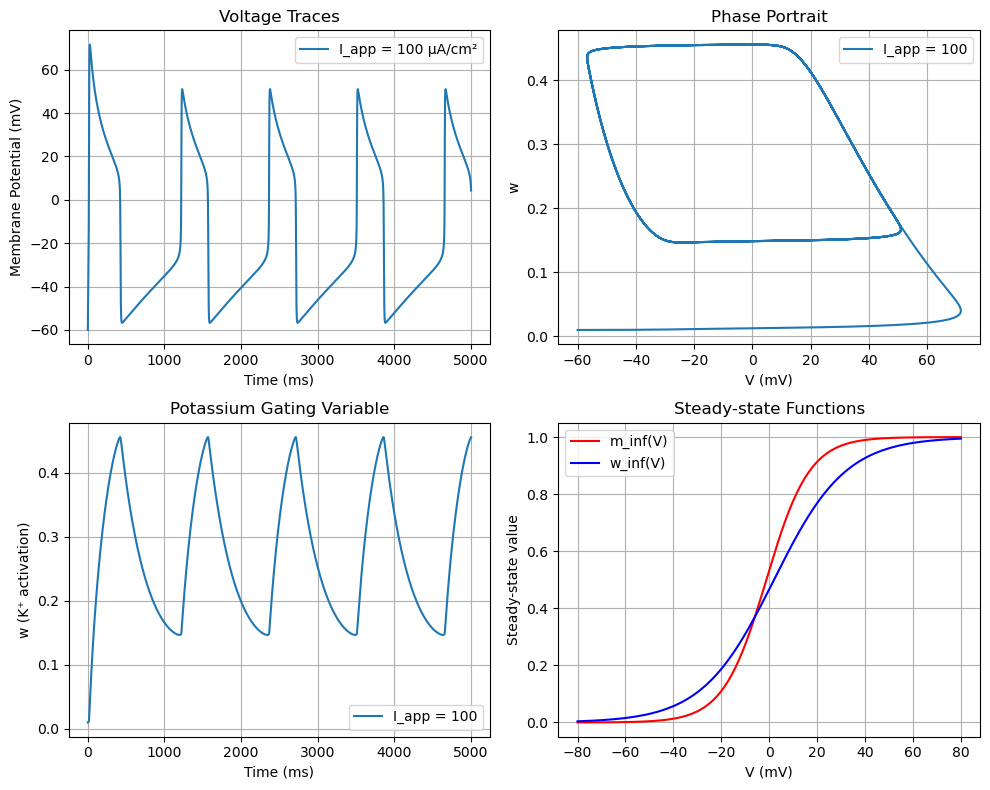

In [6]:
class MorrisLecar:
    """
    Morris-Lecar (1981) with original parameters from 
    "Voltage oscillations in the barnacle giant muscle fiber"
    """
    
    def __init__(self):
        # Original parameters
        self.C = 20.0    # μF/cm² (membrane capacitance)
        self.g_Ca = 4.4  # mS/cm² (calcium conductance)
        self.g_K = 8.0   # mS/cm² (potassium conductance)  
        self.g_L = 2.0   # mS/cm² (leak conductance)
        self.E_Ca = 120.0  # mV (calcium reversal potential)
        self.E_K = -84.0   # mV (potassium reversal potential)
        self.E_L = -60.0   # mV (leak reversal potential)
        
        # Voltage-dependent parameters
        self.V1 = -1.2    # mV (Note: it's -1.2, not +1.2)
        self.V2 = 18.0    # mV
        self.V3 = 2.0     # mV
        self.V4 = 30.0    # mV
        self.phi = 0.04   # temperature scaling factor
        
    def m_inf(self, V):
        """Steady-state activation for calcium channel"""
        return 0.5 * (1 + tanh((V - self.V1) / self.V2))
    
    def w_inf(self, V):
        """Steady-state activation for potassium channel"""
        return 0.5 * (1 + tanh((V - self.V3) / self.V4))
    
    def tau_w(self, V):
        """Time constant for potassium channel activation"""
        return 1 / (self.phi * cosh((V - self.V3) / (2 * self.V4)))
    
    def system(self, t, variables, I_app):
        """System of differential equations for solve_ivp"""
        V, w = variables
        
        # Handle both constant and time-varying current
        if callable(I_app):
            current = I_app(t)
        else:
            current = I_app
        
        # Current calculations
        I_Ca = self.g_Ca * self.m_inf(V) * (V - self.E_Ca)
        I_K  = self.g_K  * w * (V - self.E_K)
        I_L  = self.g_L  * (V - self.E_L)
        
        # Differential equations
        dV_dt = (current - I_Ca - I_K - I_L) / self.C
        dw_dt = self.phi * (self.w_inf(V) - w) / self.tau_w(V)
        
        return [dV_dt, dw_dt]
    
    def simulate(self, I_app, duration=1000, dt=0.1, V0=-60.0, w0=0.01):
        """Run simulation with applied current"""
        t_span = (0, duration)
        t_eval = arange(0, duration, dt)
        y0 = [V0, w0]
        
        solution = solve_ivp(self.system, t_span, y0, args=(I_app,), 
                           t_eval=t_eval, method='RK45', rtol=1e-6)
        
        return solution.t, solution.y[0], solution.y[1]

# Example
def main():
    ml = MorrisLecar()
    
    # Different applied currents
    currents = [100]  # μA/cm²   [40, 60, 100]
    duration = 5000  # ms
    dt = 0.1  # ms
    
    fig, axes = subplots(2, 2, figsize=(10, 8))
    
    for i, I_app in enumerate(currents):
        t, V, w = ml.simulate(I_app, duration, dt)
        
        # Voltage trace
        axes[0,0].plot(t, V, label=f'I_app = {I_app} μA/cm²')
        axes[0,0].set_ylabel('Membrane Potential (mV)')
        axes[0,0].set_xlabel('Time (ms)')
        axes[0,0].set_title('Voltage Traces')
        axes[0,0].legend()
        axes[0,0].grid(True)
        
        # Phase portrait
        axes[0,1].plot(V, w, label=f'I_app = {I_app}')
        axes[0,1].set_xlabel('V (mV)')
        axes[0,1].set_ylabel('w')
        axes[0,1].set_title('Phase Portrait')
        axes[0,1].legend()
        axes[0,1].grid(True)
        
        # Potassium gating variable
        axes[1,0].plot(t, w, label=f'I_app = {I_app}')
        axes[1,0].set_ylabel('w (K⁺ activation)')
        axes[1,0].set_xlabel('Time (ms)')
        axes[1,0].set_title('Potassium Gating Variable')
        axes[1,0].legend()
        axes[1,0].grid(True)
    
    # Steady-state functions
    V_range = linspace(-80, 80, 200)
    m_inf_vals = ml.m_inf(V_range)
    w_inf_vals = ml.w_inf(V_range)
    tau_w_vals = ml.tau_w(V_range)
    
    axes[1,1].plot(V_range, m_inf_vals, 'r-', label='m_inf(V)')
    axes[1,1].plot(V_range, w_inf_vals, 'b-', label='w_inf(V)')
    # axes[1,1].plot(V_range, tau_w_vals, 'k-', label='w_inf(V)')
    
    axes[1,1].set_xlabel('V (mV)')
    axes[1,1].set_ylabel('Steady-state value')
    axes[1,1].set_title('Steady-state Functions')
    axes[1,1].legend()
    axes[1,1].grid(True)
    
    fig.tight_layout()
    
    
    # Print parameters for verification
    print("Morris-Lecar Model Parameters (Original 1981):")
    print(f"C = {ml.C} μF/cm²")
    print(f"g_Ca = {ml.g_Ca} mS/cm²")
    print(f"g_K = {ml.g_K} mS/cm²")
    print(f"g_L = {ml.g_L} mS/cm²")
    print(f"E_Ca = {ml.E_Ca} mV")
    print(f"E_K = {ml.E_K} mV")
    print(f"E_L = {ml.E_L} mV")
    print(f"V1 = {ml.V1} mV")
    print(f"V2 = {ml.V2} mV")
    print(f"V3 = {ml.V3} mV")
    print(f"V4 = {ml.V4} mV")
    print(f"phi = {ml.phi}")

if __name__ == "__main__":
    
    main()
